In [1]:
import json
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

In [2]:
from bellem.dvc.experiment import load_experiments

experiments = load_experiments('custom-prompts-full.json')
print(f"{len(experiments)} experiments")
experiments[0]

58 experiments


{'commit': 'workspace',
 'id': 'workspace',
 'name': None,
 'params': {'dataset': {'path': 'bdsaglam/musique',
   'name': 'answerable',
   'split': 'validation'},
  'qa': {'model': 'llama-3-70b-tgi',
   'temperature': 0.1,
   'technique': 'standard'},
  'run': 1,
  'train': {'dataset': {'path': 'bdsaglam/musique-mini',
    'name': 'answerable',
    'split': 'train'},
   'optimizer': 'noop'},
  'evaluation': {'dataset': {'path': 'bdsaglam/musique',
    'name': 'answerable',
    'split': 'validation'}}},
 'metrics': {'exact_match': 0.55,
  'f1': 0.6629834609834611,
  'fuzzy_match': 0.61,
  '2hops': {'exact_match': 0.6, 'f1': 0.7348075258075258, 'fuzzy_match': 0.68},
  '3hops': {'exact_match': 0.59,
   'f1': 0.6825476190476191,
   'fuzzy_match': 0.64},
  '4hops': {'exact_match': 0.46,
   'f1': 0.5715952380952382,
   'fuzzy_match': 0.51}}}

In [7]:
df = pd.json_normalize(experiments).drop(columns=["commit", "id", "name"])

param_cols = [
    "params.dataset.path",
    "params.dataset.name",
    "params.dataset.split",
        "params.qa.model",
        "params.qa.temperature",
        "params.qa.system_prompt",
        "params.qa.user_prompt_template",
        "params.qa.few_shot_examples",
        "params.run",
]
metric_cols = [col for col in df.columns if col.startswith("metrics.")]
df.drop_duplicates(subset=param_cols, inplace=True)

df = df.sort_values(
    [
        "params.qa.model",
        "params.qa.system_prompt",
        "params.qa.user_prompt_template",
        "params.qa.few_shot_examples",
        "params.run",
    ]
)
df = df[df['params.dataset.path']=='bdsaglam/musique'].copy()
df.reset_index(drop=True, inplace=True)
df.dropna(subset=param_cols, inplace=True, how="any")

In [8]:
import re

def parse_n_shot(x):
    if 'empty' in x:
        return 0
    # match the digit in the string
    x = re.search(r'\d+', x).group()
    return int(x)

assert parse_n_shot('empty.json') == 0
assert parse_n_shot('cot-2-shot.json') == 2

In [10]:
df['params.qa.few_shot_examples'] = df['params.qa.few_shot_examples'].map(parse_n_shot)

In [11]:
df['params.qa.system_prompt'].unique().tolist()

['cot.txt',
 'cte.txt',
 'excellent-qa-cot.txt',
 'excellent-qa-cte.txt',
 'excellent-qa-few.txt',
 'excellent-qa-fewest.txt',
 'minimal-output-format-answer-cue-least.txt',
 'minimal-output-format-answer-cue.txt',
 'minimal-output-format-answer-few-no-prio.txt',
 'minimal-output-format.txt',
 'minimal.txt']

In [12]:
mapping = {
    'minimal.txt': 'm',
    'minimal-output-format.txt': 'm-o',
    'minimal-output-format-answer-cue.txt': 'm-o-few',
    'minimal-output-format-answer-cue-least.txt': 'm-o-fewest',
    'minimal-output-format-answer-few-no-prio.txt': 'm-o-few-no-prio',
    'excellent-qa-few.txt': 'exc-few',
    'excellent-qa-fewest.txt': 'exc-fewest',
    'excellent-qa-cot.txt': 'exc-cot',
    'excellent-qa-cte.txt': 'exc-cte',
    'cte.txt': 'cte',
    'cot.txt': 'cot',
}
df['params.qa.system_prompt'] = df['params.qa.system_prompt'].map(lambda x: mapping.get(x, x))

In [13]:
run_counts = (
    df.groupby(["params.qa.system_prompt", "params.qa.user_prompt_template", "params.qa.few_shot_examples"])[
        metric_cols[:1]
    ]
    .count()
    .reset_index()
)
mask = run_counts[metric_cols[0]] < 3
run_counts.loc[mask]

,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,metrics.exact_match


In [14]:
# Average metrics over repeated runs (params.run)
df_avg = (
    df.groupby(["params.qa.system_prompt", "params.qa.user_prompt_template", "params.qa.few_shot_examples"])[
        metric_cols
    ]
    .mean()
    .reset_index()
)
df_avg[["params.qa.system_prompt", 'params.qa.user_prompt_template', "params.qa.few_shot_examples", *metric_cols]].sort_values('metrics.2hops.f1', ascending=False)

,params.qa.system_prompt,params.qa.user_prompt_template,params.qa.few_shot_examples,metrics.exact_match,metrics.f1,metrics.fuzzy_match,metrics.2hops.exact_match,metrics.2hops.f1,metrics.2hops.fuzzy_match,metrics.3hops.exact_match,metrics.3hops.f1,metrics.3hops.fuzzy_match,metrics.4hops.exact_match,metrics.4hops.f1,metrics.4hops.fuzzy_match
3,cte,cq.txt,2,0.627224,0.743187,0.684181,0.660277,0.767688,0.723642,0.634211,0.768743,0.689035,0.511934,0.619488,0.553086
5,exc-cte,cq.txt,2,0.648738,0.751376,0.700041,0.666134,0.766371,0.721778,0.670175,0.783806,0.719298,0.554733,0.644163,0.596708
7,exc-few,cq.txt,2,0.599779,0.709603,0.657978,0.637114,0.741893,0.709531,0.582018,0.705804,0.632895,0.517695,0.616911,0.545679
9,exc-fewest,cq.txt,2,0.602813,0.702008,0.660874,0.635250,0.738326,0.704207,0.596491,0.692808,0.646491,0.514403,0.607001,0.553909
15,m-o-few,cq.txt,0,0.573714,0.699545,0.642670,0.621140,0.737700,0.694622,0.550439,0.706664,0.641228,0.470782,0.568233,0.484774
14,m-o-few,cq-sep.txt,0,0.569852,0.693551,0.642256,0.622204,0.735943,0.698349,0.541228,0.692944,0.635965,0.461728,0.563641,0.480658
2,cte,cq.txt,0,0.587643,0.701567,0.651083,0.621938,0.729751,0.684505,0.589035,0.719814,0.665789,0.479012,0.580201,0.520165
6,exc-few,cq.txt,0,0.568749,0.688877,0.636464,0.615815,0.729576,0.689031,0.549123,0.694474,0.631140,0.460082,0.552562,0.483951
17,m-o-fewest,cq-sep.txt,0,0.567784,0.679112,0.629982,0.618743,0.726717,0.681044,0.566228,0.679631,0.641667,0.413169,0.530976,0.450206
16,m-o-few-no-prio,cq.txt,0,0.566680,0.691031,0.636464,0.615548,0.726622,0.688765,0.538596,0.696723,0.629825,0.468313,0.570327,0.487243


In [15]:
df_target = df_avg.copy()
df_target.sort_values('metrics.f1', inplace=True)

In [16]:
mask = df_target['params.qa.few_shot_examples'] == 0
df_target.loc[mask].sort_values('metrics.f1', ascending=False).drop(columns=['params.qa.few_shot_examples'])

,params.qa.system_prompt,params.qa.user_prompt_template,metrics.exact_match,metrics.f1,metrics.fuzzy_match,metrics.2hops.exact_match,metrics.2hops.f1,metrics.2hops.fuzzy_match,metrics.3hops.exact_match,metrics.3hops.f1,metrics.3hops.fuzzy_match,metrics.4hops.exact_match,metrics.4hops.f1,metrics.4hops.fuzzy_match
2,cte,cq.txt,0.587643,0.701567,0.651083,0.621938,0.729751,0.684505,0.589035,0.719814,0.665789,0.479012,0.580201,0.520165
15,m-o-few,cq.txt,0.573714,0.699545,0.642670,0.621140,0.737700,0.694622,0.550439,0.706664,0.641228,0.470782,0.568233,0.484774
14,m-o-few,cq-sep.txt,0.569852,0.693551,0.642256,0.622204,0.735943,0.698349,0.541228,0.692944,0.635965,0.461728,0.563641,0.480658
16,m-o-few-no-prio,cq.txt,0.566680,0.691031,0.636464,0.615548,0.726622,0.688765,0.538596,0.696723,0.629825,0.468313,0.570327,0.487243
6,exc-few,cq.txt,0.568749,0.688877,0.636464,0.615815,0.729576,0.689031,0.549123,0.694474,0.631140,0.460082,0.552562,0.483951
18,m-o-fewest,cq.txt,0.567922,0.679438,0.629017,0.612886,0.721228,0.674121,0.572368,0.689424,0.648684,0.420576,0.531514,0.452675
17,m-o-fewest,cq-sep.txt,0.567784,0.679112,0.629982,0.618743,0.726717,0.681044,0.566228,0.679631,0.641667,0.413169,0.530976,0.450206
8,exc-fewest,cq.txt,0.563508,0.677083,0.632051,0.612087,0.723825,0.679446,0.547368,0.672445,0.635526,0.443621,0.541292,0.479012
12,m-o,cq-sep.txt,0.540063,0.663720,0.599366,0.593450,0.722551,0.664537,0.518421,0.655120,0.580702,0.415638,0.497995,0.432922
13,m-o,cq.txt,0.535788,0.659685,0.592884,0.588658,0.718511,0.657614,0.522807,0.656993,0.580702,0.396708,0.482884,0.415638


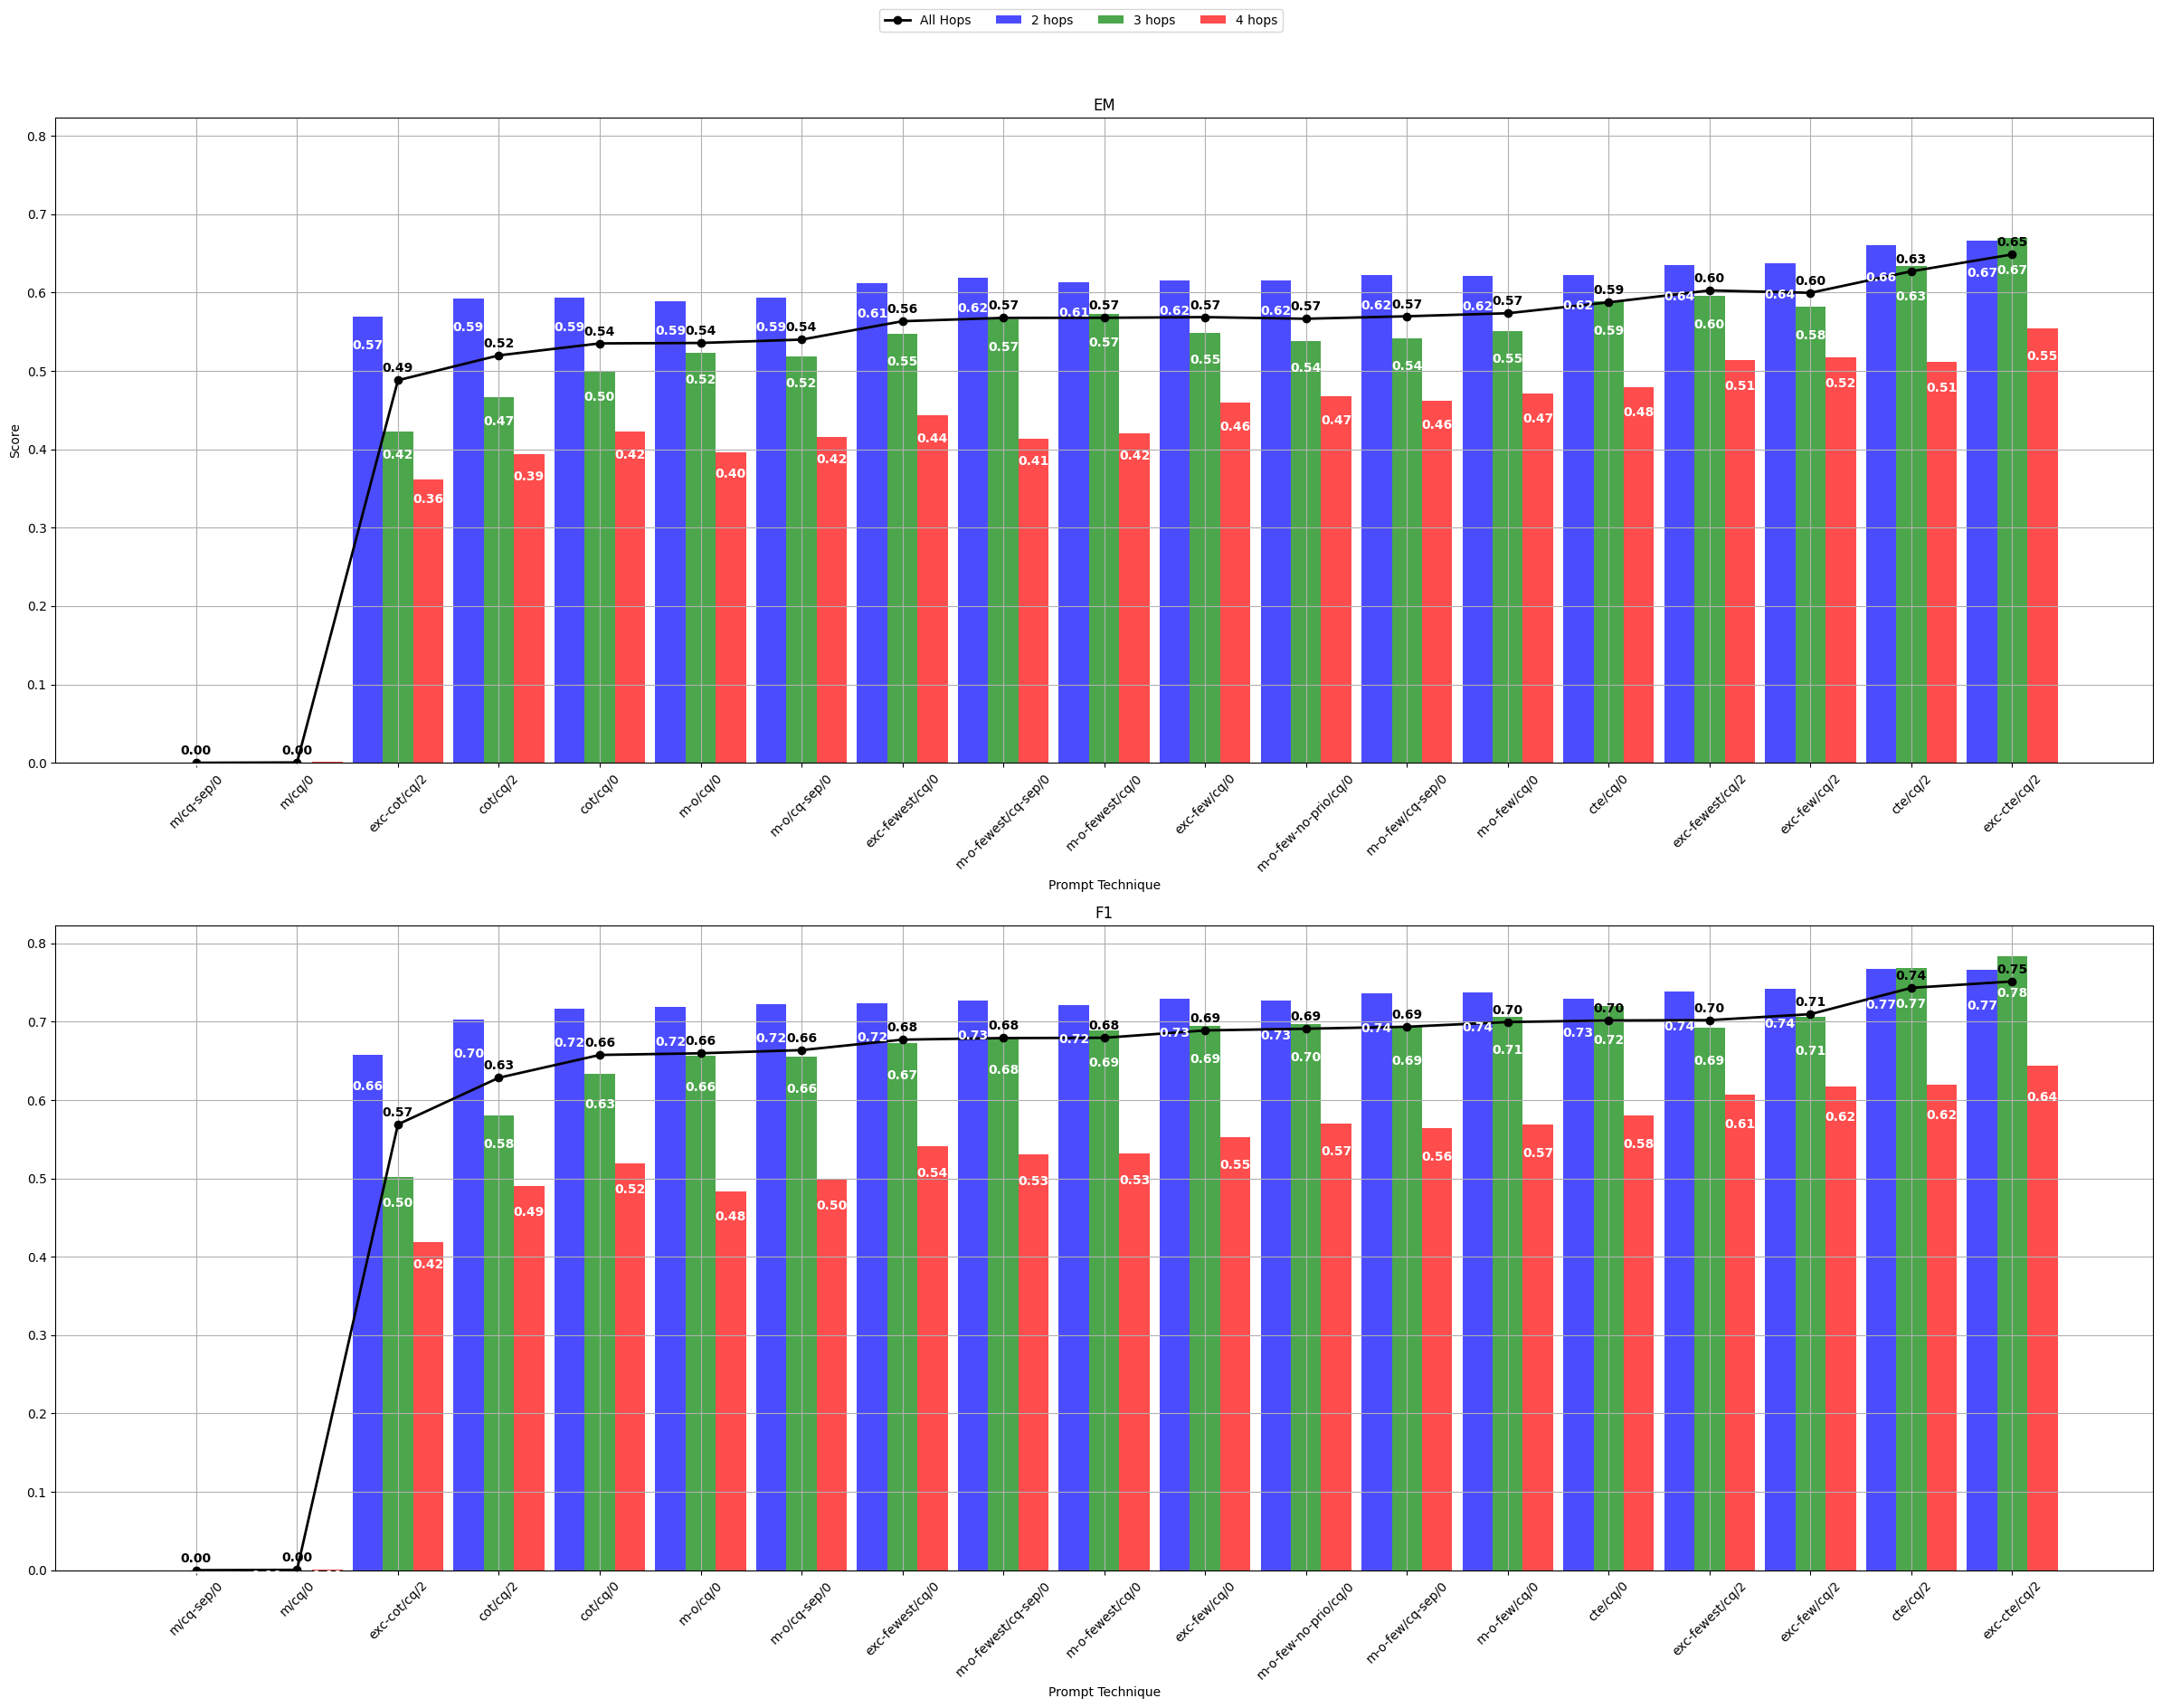

In [17]:
def plot_metric(ax, x, width, prompts, metrics, title, ylabel=None):
    bars_2hops = ax.bar(x - width, metrics["2hops"], width, label="2 hops", color="b", alpha=0.7)
    bars_3hops = ax.bar(x, metrics["3hops"], width, label="3 hops", color="g", alpha=0.7)
    bars_4hops = ax.bar(x + width, metrics["4hops"], width, label="4 hops", color="r", alpha=0.7)

    # Plotting all hops as a line plot
    ax.plot(x, metrics["all"], label="All Hops", color="k", linestyle="-", marker="o", linewidth=2)

    # Adding values inside the bars, just below the top
    for bars in [bars_2hops, bars_3hops, bars_4hops]:
        for bar in bars:
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                bar.get_height() - (bar.get_height() * 0.05),
                f"{bar.get_height():.2f}",
                ha="center",
                va="top",
                fontsize=10,
                color="white",
                fontweight="bold",
            )

    # Adding values on top of the line plot
    for i, value in enumerate(metrics["all"]):
        ax.text(
            x[i],
            value + 0.007,
            f"{value:.2f}",
            ha="center",
            va="bottom",
            fontsize=10,
            fontweight="bold",
        )

    # Adjust titles and labels
    ax.set_title(title)
    ax.set_xlabel("Prompt Technique")
    ax.set_xticks(x)
    ax.set_xticklabels([prompt.replace(".txt", "") for prompt in prompts], rotation=45)
    if ylabel:
        ax.set_ylabel(ylabel)
    ax.grid(True)


# Creating subplots for Exact Match and F1, separating them for clarity
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(24, 18), sharey=True)

width = 0.3  # Bar width adjustment

# Changing the order of prompts to standard, cot-zs, cot-fs, cte
prompts = [f"{sp}/{up}/{fs}" for sp, up, fs in zip(df_target['params.qa.system_prompt'].values, df_target["params.qa.user_prompt_template"].values, df_target['params.qa.few_shot_examples'].values)]
x = np.arange(len(prompts))

# Plotting Exact Match
metrics_em = {
    "2hops": df_target["metrics.2hops.exact_match"].values,
    "3hops": df_target["metrics.3hops.exact_match"].values,
    "4hops": df_target["metrics.4hops.exact_match"].values,
    "all": df_target["metrics.exact_match"].values,
}
plot_metric(ax1, x, width, prompts, metrics_em, title="EM", ylabel="Score")

# Plotting F1
metrics_f1 = {
    "2hops": df_target["metrics.2hops.f1"].values,
    "3hops": df_target["metrics.3hops.f1"].values,
    "4hops": df_target["metrics.4hops.f1"].values,
    "all": df_target["metrics.f1"].values,
}
plot_metric(ax2, x, width, prompts, metrics_f1, title="F1")

# Creating a shared legend outside the plots
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=4)

plt.tight_layout()
plt.show()